## 一维卷积神经网络处理IMDB数据

2022-04-26 15:50:28.319373: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1


Loading data...
25000 train sequences
25000 test sequences
Pad sequences (samples x time)
x_train shape: (25000, 500)
x_test shape: (25000, 500)


2022-04-26 15:50:35.228030: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcuda.so.1
2022-04-26 15:50:35.298428: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1716] Found device 0 with properties: 
pciBusID: 0000:03:00.0 name: NVIDIA TITAN Xp computeCapability: 6.1
coreClock: 1.582GHz coreCount: 30 deviceMemorySize: 11.91GiB deviceMemoryBandwidth: 510.07GiB/s
2022-04-26 15:50:35.298465: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1
2022-04-26 15:50:35.300466: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcublas.so.10
2022-04-26 15:50:35.302169: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcufft.so.10
2022-04-26 15:50:35.302447: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcurand.so.10


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 500, 128)          1280000   
_________________________________________________________________
conv1d (Conv1D)              (None, 494, 32)           28704     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 98, 32)            0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 92, 32)            7200      
_________________________________________________________________
global_max_pooling1d (Global (None, 32)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 33        
Total params: 1,315,937
Trainable params: 1,315,937
Non-trainable params: 0
______________________________________________

2022-04-26 15:50:37.226138: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcublas.so.10
2022-04-26 15:50:37.419891: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudnn.so.7


157/157 [==============================] - 5s 30ms/step - loss: 0.9005 - acc: 0.5084 - val_loss: 0.6886 - val_acc: 0.5326
Epoch 2/10
157/157 [==============================] - 4s 27ms/step - loss: 0.6717 - acc: 0.6470 - val_loss: 0.6671 - val_acc: 0.6324
Epoch 3/10
157/157 [==============================] - 4s 28ms/step - loss: 0.6289 - acc: 0.7510 - val_loss: 0.6226 - val_acc: 0.6784
Epoch 4/10
157/157 [==============================] - 4s 27ms/step - loss: 0.5420 - acc: 0.8030 - val_loss: 0.5114 - val_acc: 0.7902
Epoch 5/10
157/157 [==============================] - 4s 27ms/step - loss: 0.4152 - acc: 0.8439 - val_loss: 0.4206 - val_acc: 0.8336
Epoch 6/10
157/157 [==============================] - 4s 26ms/step - loss: 0.3442 - acc: 0.8727 - val_loss: 0.4036 - val_acc: 0.8532
Epoch 7/10
157/157 [==============================] - 4s 27ms/step - loss: 0.3057 - acc: 0.8924 - val_loss: 0.4156 - val_acc: 0.8596
Epoch 8/10
157/157 [==============================] - 4s 27ms/step - loss: 0.267

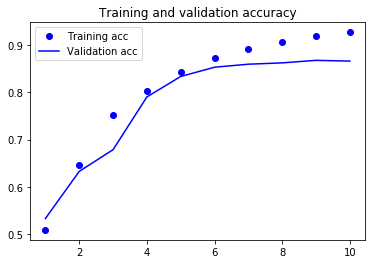

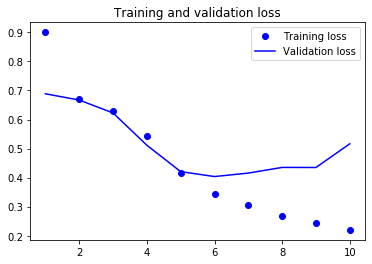

In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

from tensorflow.keras.datasets import imdb
from tensorflow.keras.preprocessing import sequence

# 获取数据
max_features = 10000
max_len = 500
print('Loading data...')
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=max_features)
print(len(x_train), 'train sequences')
print(len(x_test), 'test sequences')
print('Pad sequences (samples x time)')
x_train = sequence.pad_sequences(x_train, maxlen=max_len)
x_test = sequence.pad_sequences(x_test, maxlen=max_len)
print('x_train shape:', x_train.shape)
print('x_test shape:', x_test.shape)

# 训练模型
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.optimizers import RMSprop

model = Sequential()
model.add(layers.Embedding(max_features, 128, input_length=max_len))
model.add(layers.Conv1D(32, 7, activation='relu'))
# 5个里面选一个最大的
model.add(layers.MaxPooling1D(5))
model.add(layers.Conv1D(32, 7, activation='relu'))
# 全部里面选一个最大的
model.add(layers.GlobalMaxPooling1D())
model.add(layers.Dense(1))
model.summary()
model.compile(optimizer=RMSprop(learning_rate=1e-4),
              loss='binary_crossentropy',
              metrics=['acc'])
history = model.fit(x_train, y_train,
                    epochs=10,
                    batch_size=128,
                    validation_split=0.2)

# 绘制结果
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

## 要想结合卷积神经网络的速度和轻量与 RNN 的顺序敏感性，一种方法是在 RNN 前面使用一维卷积神经网络作为预处理步骤（见图 6-30）。对于那些非常长，以至于 RNN 无法处理的序列（比如包含上千个时间步的序列），这种方法尤其有用。卷积神经网络可以将长的输入序列转换为高级特征组成的更短序列（下采样）。然后，提取的特征组成的这些序列成为网络中 RNN 的输入。